# Speech Recognition Neural Network Comparison

## Litha Thampan



---
## Visualize Audio

soundfile can be used to load Wav file to a floating point time series which can be plotted using matplotlib


---

In [3]:

from data_viz import AudioVisualizer

viz_obj = AudioVisualizer(index=1)


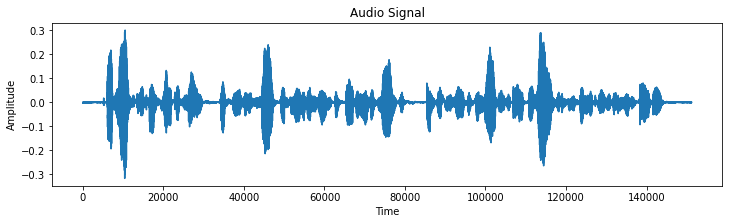

**Shape of Audio Signal** : (151200,)

**Transcript** : at last he sent word to say that he himself would be in england before the end of march and would see that the majesty of the law should be vindicated in his favour

In [4]:
from IPython.display import Audio
from IPython.display import Markdown, display
viz_obj.plot_raw_audio()
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(viz_obj.vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(viz_obj.vis_text)))
# Audio Play 
Audio(viz_obj.vis_audio_path)

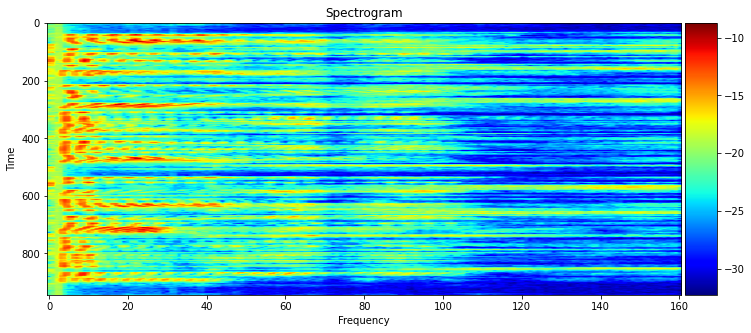

**Shape of Spectrogram** : (944, 161)

In [19]:
viz_obj.plot_spectrogram_feature(normalized = False)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(viz_obj.vis_spectrogram_feature.shape)))

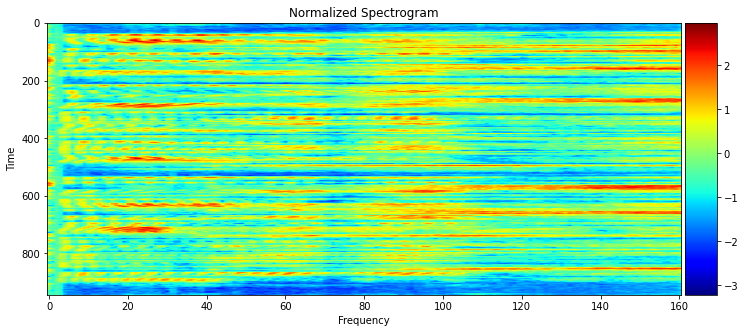

**Shape of Spectrogram** : (944, 161)

In [20]:
viz_obj.plot_spectrogram_feature(normalized = True)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(viz_obj.vis_spectrogram_feature_norm.shape)))

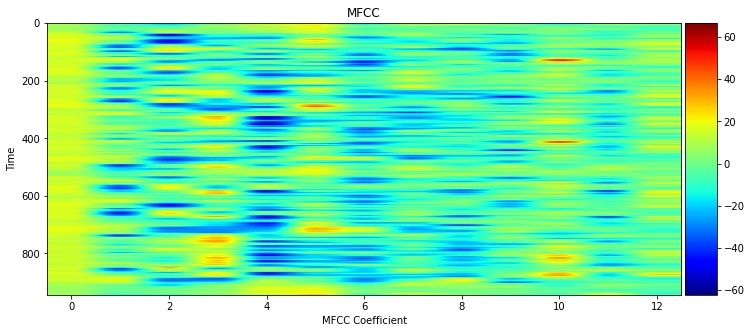

**Shape of MFCC** : (944, 13)

In [21]:
viz_obj.plot_mfcc_feature(normalized=False)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(viz_obj.vis_mfcc_feature.shape)))

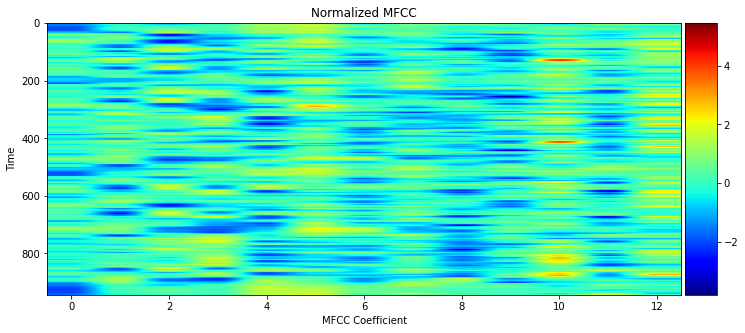

**Shape of MFCC** : (944, 13)

In [22]:
viz_obj.plot_mfcc_feature(normalized=True)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(viz_obj.vis_mfcc_feature_norm.shape)))

In [1]:
import tensorflow as tf
# For TEnsorflow 1.1 and Keras 2.0.5
'''
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config)
'''            
# For TensofrFlow 2.0

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
tf.config.experimental.set_visible_devices(devices= physical_devices, device_type='GPU')
#tf.config.experimental.set_visible_devices([], 'GPU')
# To find out which devices your operations and tensors are assigned to
#tf.debugging.set_log_device_placement(True)
    

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension
%load_ext tensorboard
# import NN architectures for speech recognition
from model_gen import *
# import function for training acoustic model
from train_utils import train_model


In [14]:
simple_mfcc = simple_rnn_model(input_dim=13,cell=SimpleRNN,name='simple_mfcc') # input_dim: 13 for MFCC, 161 for Spectrogram
lstm_mfcc = simple_rnn_model(input_dim=13,cell=LSTM,name='lstm_mfcc') 
gru_mfcc = simple_rnn_model(input_dim=13,cell=GRU,name='gru_mfcc')
simple_spectrogram = simple_rnn_model(input_dim=161,cell=SimpleRNN,name='simple_spectrogram') # input_dim: 13 for MFCC, 161 for Spectrogram
lstm_spectrogram = simple_rnn_model(input_dim=161,cell=LSTM,name='lstm_spectrogram') 
gru_spectrogram = simple_rnn_model(input_dim=161,cell=GRU,name='gru_spectrogram')

Model: "simple_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 29)          1247      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 1,247
Trainable params: 1,247
Non-trainable params: 0
_________________________________________________________________
None
Model: "lstm_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
rnn (LSTM)                   (None, None, 29)          4988      
_____________________________

In [15]:
train_model(input_to_softmax=simple_mfcc, 
            pickle_path='simple_mfcc.pickle', 
            save_model_path='simple_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 104s 980ms/step - loss: 1029.9824 - mean_absolute_error: 1029.9821 - val_loss: 855.4147 - val_mean_absolute_error: 855.4147
Epoch 2/20
106/106 [==============================] - 108s 1s/step - loss: 820.0125 - mean_absolute_error: 820.0124 - val_loss: 755.1944 - val_mean_absolute_error: 755.1946
Epoch 3/20
106/106 [==============================] - 108s 1s/step - loss: 775.3206 - mean_absolute_error: 775.3205 - val_loss: 742.2603 - val_mean_absolute_error: 742.2603
Epoch 4/20
106/106 [==============================] - 111s 1s/step - loss: 764.7468 - mean_absolute_error: 764.7468 - val_loss: 734.4122 - val_mean_absolute_error: 734.4124
Epoch 5/20
106/106 [==============================] - 110s 1s/step - loss: 761.4327 - mean_absolute_error: 761.4328 - val_loss: 729.9106 - val_mean_absolute_error: 729.9106
Epoch 6/20
106

In [16]:
train_model(input_to_softmax=lstm_mfcc, 
            pickle_path='lstm_mfcc.pickle', 
            save_model_path='lstm_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 86s 807ms/step - loss: 975.0764 - mean_absolute_error: 975.0765 - val_loss: 776.6497 - val_mean_absolute_error: 776.6500
Epoch 2/20
106/106 [==============================] - 78s 739ms/step - loss: 772.7815 - mean_absolute_error: 772.7816 - val_loss: 728.2177 - val_mean_absolute_error: 728.2178
Epoch 3/20
106/106 [==============================] - 80s 753ms/step - loss: 755.8554 - mean_absolute_error: 755.8553 - val_loss: 735.6283 - val_mean_absolute_error: 735.6285
Epoch 4/20
106/106 [==============================] - 80s 755ms/step - loss: 753.7020 - mean_absolute_error: 753.7022 - val_loss: 727.6112 - val_mean_absolute_error: 727.6113
Epoch 5/20
106/106 [==============================] - 80s 754ms/step - loss: 754.2063 - mean_absolute_error: 754.2064 - val_loss: 731.8039 - val_mean_absolute_error: 731.8041
Epoch 6/2

In [17]:
train_model(input_to_softmax=gru_mfcc, 
            pickle_path='gru_mfcc.pickle', 
            save_model_path='gru_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 85s 798ms/step - loss: 903.5080 - mean_absolute_error: 903.5079 - val_loss: 729.1536 - val_mean_absolute_error: 729.1537
Epoch 2/20
106/106 [==============================] - 77s 730ms/step - loss: 753.3483 - mean_absolute_error: 753.3482 - val_loss: 732.7586 - val_mean_absolute_error: 732.7587
Epoch 3/20
106/106 [==============================] - 81s 763ms/step - loss: 754.4078 - mean_absolute_error: 754.4079 - val_loss: 724.2090 - val_mean_absolute_error: 724.2089
Epoch 4/20
106/106 [==============================] - 79s 750ms/step - loss: 752.7956 - mean_absolute_error: 752.7956 - val_loss: 725.1809 - val_mean_absolute_error: 725.1811
Epoch 5/20
106/106 [==============================] - 80s 756ms/step - loss: 752.8178 - mean_absolute_error: 752.8176 - val_loss: 733.4319 - val_mean_absolute_error: 733.4318
Epoch 6/2

In [18]:
train_model(input_to_softmax=simple_spectrogram, 
            pickle_path='simple_spectrogram.pickle', 
            save_model_path='simple_spectrogram.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 51s 482ms/step - loss: 1169.7387 - mean_absolute_error: 1169.7388 - val_loss: 1167.5906 - val_mean_absolute_error: 1167.5906
Epoch 2/20
106/106 [==============================] - 51s 478ms/step - loss: 1030.0619 - mean_absolute_error: 1030.0619 - val_loss: 919.2659 - val_mean_absolute_error: 919.2659
Epoch 3/20
106/106 [==============================] - 50s 470ms/step - loss: 913.3540 - mean_absolute_error: 913.3541 - val_loss: 909.1334 - val_mean_absolute_error: 909.1333
Epoch 4/20
106/106 [==============================] - 50s 467ms/step - loss: 792.9922 - mean_absolute_error: 792.9922 - val_loss: 735.2254 - val_mean_absolute_error: 735.2255
Epoch 5/20
106/106 [==============================] - 50s 467ms/step - loss: 772.2591 - mean_absolute_error: 772.2593 - val_loss: 732.7552 - val_mean_absolute_error: 732.7553
Epo

In [19]:
train_model(input_to_softmax=lstm_spectrogram, 
            pickle_path='lstm_spectrogram.pickle', 
            save_model_path='lstm_spectrogram.h5',
            spectrogram=True) 

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 24s 225ms/step - loss: 925.3337 - mean_absolute_error: 925.3336 - val_loss: 751.3485 - val_mean_absolute_error: 751.3485
Epoch 2/20
106/106 [==============================] - 22s 206ms/step - loss: 765.7486 - mean_absolute_error: 765.7485 - val_loss: 734.9968 - val_mean_absolute_error: 734.9966
Epoch 3/20
106/106 [==============================] - 22s 207ms/step - loss: 754.1268 - mean_absolute_error: 754.1267 - val_loss: 719.7055 - val_mean_absolute_error: 719.7054
Epoch 4/20
106/106 [==============================] - 22s 207ms/step - loss: 753.6638 - mean_absolute_error: 753.6637 - val_loss: 723.9902 - val_mean_absolute_error: 723.9903
Epoch 5/20
106/106 [==============================] - 22s 211ms/step - loss: 752.6959 - mean_absolute_error: 752.6958 - val_loss: 728.6489 - val_mean_absolute_error: 728.6489
Epoch 6/2

In [20]:
train_model(input_to_softmax=gru_spectrogram, 
            pickle_path='gru_spectrogram.pickle', 
            save_model_path='gru_spectrogram.h5',
            spectrogram=True)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 24s 230ms/step - loss: 852.0466 - mean_absolute_error: 852.0469 - val_loss: 738.2920 - val_mean_absolute_error: 738.2921
Epoch 2/20
106/106 [==============================] - 22s 211ms/step - loss: 760.1843 - mean_absolute_error: 760.1841 - val_loss: 736.8227 - val_mean_absolute_error: 736.8229
Epoch 3/20
106/106 [==============================] - 22s 210ms/step - loss: 756.6246 - mean_absolute_error: 756.6245 - val_loss: 723.5523 - val_mean_absolute_error: 723.5524
Epoch 4/20
106/106 [==============================] - 23s 213ms/step - loss: 757.3603 - mean_absolute_error: 757.3602 - val_loss: 737.0551 - val_mean_absolute_error: 737.0553
Epoch 5/20
106/106 [==============================] - 22s 209ms/step - loss: 757.5021 - mean_absolute_error: 757.5021 - val_loss: 733.7370 - val_mean_absolute_error: 733.7370
Epoch 6/2

In [23]:
rnn_mfcc = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu',name='rnn_mfcc')
rnn_spectrogram = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu',name='rnn_spectrogram')

Model: "rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         129000    
_________________________________________________________________
bn_rnn_1d (BatchNormalizatio (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,629
Trainable params: 135,229
Non-trainable params: 400
_________________________________________________________________
None
Model: "rnn_spectrogram"
_________________________________________________________________
Layer (type)        

In [24]:
train_model(input_to_softmax=rnn_mfcc, 
            pickle_path='rnn_mfcc.pickle', 
            save_model_path='rnn_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 133s 1s/step - loss: 322.8615 - mean_absolute_error: 322.8614 - val_loss: 327.6376 - val_mean_absolute_error: 327.6376
Epoch 2/20
106/106 [==============================] - 130s 1s/step - loss: 243.9735 - mean_absolute_error: 243.9735 - val_loss: 266.3048 - val_mean_absolute_error: 266.3048
Epoch 3/20
106/106 [==============================] - 133s 1s/step - loss: 227.2406 - mean_absolute_error: 227.2407 - val_loss: 246.3160 - val_mean_absolute_error: 246.3159
Epoch 4/20
106/106 [==============================] - 133s 1s/step - loss: 214.0692 - mean_absolute_error: 214.0692 - val_loss: 220.9219 - val_mean_absolute_error: 220.9219
Epoch 5/20
106/106 [==============================] - 135s 1s/step - loss: 203.6109 - mean_absolute_error: 203.6109 - val_loss: 195.2728 - val_mean_absolute_error: 195.2728
Epoch 6/20
106/106 

In [25]:
train_model(input_to_softmax=rnn_spectrogram, 
            pickle_path='rnn_spectrogram.pickle', 
            save_model_path='rnn_spectrogram.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 81s 760ms/step - loss: 308.1718 - mean_absolute_error: 308.1719 - val_loss: 257.8394 - val_mean_absolute_error: 257.8394
Epoch 2/20
106/106 [==============================] - 79s 749ms/step - loss: 242.2050 - mean_absolute_error: 242.2050 - val_loss: 232.7726 - val_mean_absolute_error: 232.7727
Epoch 3/20
106/106 [==============================] - 80s 755ms/step - loss: 225.4482 - mean_absolute_error: 225.4483 - val_loss: 216.0068 - val_mean_absolute_error: 216.0069
Epoch 4/20
106/106 [==============================] - 80s 753ms/step - loss: 215.4045 - mean_absolute_error: 215.4045 - val_loss: 205.6867 - val_mean_absolute_error: 205.6868
Epoch 5/20
106/106 [==============================] - 79s 744ms/step - loss: 204.9819 - mean_absolute_error: 204.9819 - val_loss: 193.7588 - val_mean_absolute_error: 193.7588
Epoch 6/2

In [26]:
cnn_rnn_mfcc = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        name='cnn_rnn_mfcc')
cnn_rnn_spectrogram = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        name='cnn_rnn_spectrogram')

Model: "cnn_rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         241200    
_________________________________________________________________
gru_rnn (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)         

In [27]:
train_model(input_to_softmax=cnn_rnn_mfcc, 
            pickle_path='cnn_rnn_mfcc.pickle', 
            save_model_path='cnn_rnn_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 100s 942ms/step - loss: 251.1503 - mean_absolute_error: 251.1503 - val_loss: 220.5802 - val_mean_absolute_error: 220.5802
Epoch 2/20
106/106 [==============================] - 98s 929ms/step - loss: 212.9589 - mean_absolute_error: 212.9590 - val_loss: 189.2587 - val_mean_absolute_error: 189.2587
Epoch 3/20
106/106 [==============================] - 100s 942ms/step - loss: 182.8960 - mean_absolute_error: 182.8960 - val_loss: 174.9404 - val_mean_absolute_error: 174.9404
Epoch 4/20
106/106 [==============================] - 100s 948ms/step - loss: 162.2645 - mean_absolute_error: 162.2645 - val_loss: 155.3201 - val_mean_absolute_error: 155.3201
Epoch 5/20
106/106 [==============================] - 98s 929ms/step - loss: 148.7589 - mean_absolute_error: 148.7588 - val_loss: 146.5193 - val_mean_absolute_error: 146.5193
Epoch 

In [28]:
train_model(input_to_softmax=cnn_rnn_spectrogram, 
            pickle_path='cnn_rnn_spectrogram.pickle', 
            save_model_path='cnn_rnn_spectrogram.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 49s 459ms/step - loss: 248.1716 - mean_absolute_error: 248.1717 - val_loss: 251.5454 - val_mean_absolute_error: 251.5455
Epoch 2/20
106/106 [==============================] - 46s 436ms/step - loss: 220.9068 - mean_absolute_error: 220.9068 - val_loss: 211.1219 - val_mean_absolute_error: 211.1219
Epoch 3/20
106/106 [==============================] - 46s 437ms/step - loss: 206.0412 - mean_absolute_error: 206.0412 - val_loss: 193.1328 - val_mean_absolute_error: 193.1329
Epoch 4/20
106/106 [==============================] - 47s 447ms/step - loss: 183.9690 - mean_absolute_error: 183.9690 - val_loss: 174.6276 - val_mean_absolute_error: 174.6276
Epoch 5/20
106/106 [==============================] - 48s 449ms/step - loss: 166.0562 - mean_absolute_error: 166.0562 - val_loss: 160.3568 - val_mean_absolute_error: 160.3567
Epoch 6/2

In [94]:
cnn_pool_rnn_mfcc = cnn_pool_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        name='cnn_pool_rnn_mfcc')

Model: "cnn_pool_rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, None, 200)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         241200    
_________________________________________________________________
gru_rnn (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_distributed_29 (TimeDis (None, None, 29)    

In [95]:
from tensorflow.keras.optimizers import RMSprop,Adam
train_model(input_to_softmax=cnn_pool_rnn_mfcc, 
            pickle_path='cnn_pool_rnn_mfcc.pickle', 
            save_model_path='cnn_pool_rnn_mfcc.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
  1/106 [..............................] - ETA: 3:26

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  sequence_length(0) <= 235
	 [[node model_25/ctc/CTCLoss (defined at /home/litha/mlproject/speech_recognition_nn_comparison/train_utils.py:22) ]]
  (1) Invalid argument:  sequence_length(0) <= 235
	 [[node model_25/ctc/CTCLoss (defined at /home/litha/mlproject/speech_recognition_nn_comparison/train_utils.py:22) ]]
	 [[model_25/ctc/CTCLoss/_92]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_311763]

Function call stack:
distributed_function -> distributed_function


In [29]:
deep_rnn_mfcc = deep_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2,
                         name='deep_rnn_mfcc') 
deep_rnn_spectrogram = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2,
                         name='deep_rnn_spectrogram') 

Model: "deep_rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
gru (GRU)                    (None, None, 200)         129000    
_________________________________________________________________
bt_rnn_1 (BatchNormalization (None, None, 200)         800       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 200)         241200    
_________________________________________________________________
bt_rnn_last_rnn (BatchNormal (None, None, 200)         800       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)        

In [30]:
train_model(input_to_softmax=deep_rnn_mfcc, 
            pickle_path='deep_rnn_mfcc.pickle', 
            save_model_path='deep_rnn_mfcc.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 212s 2s/step - loss: 300.3492 - mean_absolute_error: 300.3492 - val_loss: 283.6690 - val_mean_absolute_error: 283.6690
Epoch 2/20
106/106 [==============================] - 208s 2s/step - loss: 235.8867 - mean_absolute_error: 235.8867 - val_loss: 229.0644 - val_mean_absolute_error: 229.0644
Epoch 3/20
106/106 [==============================] - 206s 2s/step - loss: 219.4724 - mean_absolute_error: 219.4724 - val_loss: 212.0234 - val_mean_absolute_error: 212.0234
Epoch 4/20
106/106 [==============================] - 204s 2s/step - loss: 212.2729 - mean_absolute_error: 212.2730 - val_loss: 200.1448 - val_mean_absolute_error: 200.1448
Epoch 5/20
106/106 [==============================] - 201s 2s/step - loss: 204.2490 - mean_absolute_error: 204.2490 - val_loss: 196.5123 - val_mean_absolute_error: 196.5123
Epoch 6/20
106/106 

In [31]:
train_model(input_to_softmax=deep_rnn_spectrogram, 
            pickle_path='deep_rnn_spectrogram.pickle', 
            save_model_path='deep_rnn_spectrogram.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 144s 1s/step - loss: 285.4599 - mean_absolute_error: 285.4599 - val_loss: 228.4308 - val_mean_absolute_error: 228.4308
Epoch 2/20
106/106 [==============================] - 143s 1s/step - loss: 232.0181 - mean_absolute_error: 232.0180 - val_loss: 220.5728 - val_mean_absolute_error: 220.5728
Epoch 3/20
106/106 [==============================] - 142s 1s/step - loss: 225.2943 - mean_absolute_error: 225.2944 - val_loss: 215.7357 - val_mean_absolute_error: 215.7357
Epoch 4/20
106/106 [==============================] - 142s 1s/step - loss: 220.6338 - mean_absolute_error: 220.6338 - val_loss: 211.4075 - val_mean_absolute_error: 211.4075
Epoch 5/20
106/106 [==============================] - 142s 1s/step - loss: 219.2466 - mean_absolute_error: 219.2466 - val_loss: 224.3080 - val_mean_absolute_error: 224.3080
Epoch 6/20
106/106 

In [3]:
bidirectional_rnn_mfcc = bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                  units=200,
                                  name='bidirectional_rnn_mfcc')
bidirectional_rnn_spectrogram = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200,
                                  name='bidirectional_rnn_spectrogram')

Model: "bidirectional_rnn_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 400)         258000    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 269,629
Trainable params: 269,629
Non-trainable params: 0
_________________________________________________________________
None
Model: "bidirectional_rnn_spectrogram"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 161)]       0    

In [4]:
from tensorflow.keras.optimizers import RMSprop,Adam
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.9999, amsgrad=False)
train_model(input_to_softmax=bidirectional_rnn_mfcc, 
            pickle_path='bidirectional_rnn_mfcc.pickle', 
            save_model_path='bidirectional_rnn_mfcc.h5',
            optimizer = optimizer,
            spectrogram=False) # change to False if you would like to use MFCC features

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 198s 2s/step - loss: 488.4158 - mean_absolute_error: 488.4159 - val_loss: 222.6766 - val_mean_absolute_error: 222.6765
Epoch 2/20
106/106 [==============================] - 199s 2s/step - loss: 228.9722 - mean_absolute_error: 228.9722 - val_loss: 219.4210 - val_mean_absolute_error: 219.4210
Epoch 3/20
106/106 [==============================] - 199s 2s/step - loss: 226.0766 - mean_absolute_error: 226.0766 - val_loss: 216.0495 - val_mean_absolute_error: 216.0495
Epoch 4/20
106/106 [==============================] - 198s 2s/step - loss: 223.5333 - mean_absolute_error: 223.5334 - val_loss: 211.9018 - val_mean_absolute_error: 211.9018
Epoch 5/20
106/106 [==============================] - 201s 2s/step - loss: 221.1194 - mean_absolute_error: 221.1194 - val_loss: 208.7073 - val_mean_absolute_error: 208.7073
Epoch 6/20
106/106 

In [5]:
train_model(input_to_softmax=bidirectional_rnn_spectrogram, 
            pickle_path='bidirectional_rnn_spectrogram.pickle', 
            save_model_path='bidirectional_rnn_spectrogram.h5',
            optimizer = optimizer,
            spectrogram=True)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 106 steps, validate for 100 steps
Epoch 1/20
106/106 [==============================] - 147s 1s/step - loss: 284.9434 - mean_absolute_error: 284.9435 - val_loss: 245.0017 - val_mean_absolute_error: 245.0017
Epoch 2/20
106/106 [==============================] - 142s 1s/step - loss: 236.2507 - mean_absolute_error: 236.2507 - val_loss: 222.1372 - val_mean_absolute_error: 222.1372
Epoch 3/20
106/106 [==============================] - 143s 1s/step - loss: 224.5377 - mean_absolute_error: 224.5377 - val_loss: 211.0649 - val_mean_absolute_error: 211.0649
Epoch 4/20
106/106 [==============================] - 142s 1s/step - loss: 211.5887 - mean_absolute_error: 211.5887 - val_loss: 195.0187 - val_mean_absolute_error: 195.0187
Epoch 5/20
106/106 [==============================] - 141s 1s/step - loss: 189.6717 - mean_absolute_error: 189.6717 - val_loss: 176.0456 - val_mean_absolute_error: 176.0455
Epoch 6/20
106/106 

In [3]:
# specify the model
final_model_mfcc = final_model(input_dim=13,
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=250,
                        activation='relu',
                        cell=GRU,
                        dropout_rate=0.5,
                        number_of_layers=2,
                        name='final_model_mfcc')
final_model_spectrogram = final_model(input_dim=161,
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=250,
                        activation='relu',
                        cell=GRU,
                        dropout_rate=0.5,
                        number_of_layers=2,
                        name='final_model_spectrogram')

Model: "final_model_mfcc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
layer_1_conv (Conv1D)        (None, None, 200)         28800     
_________________________________________________________________
conv_batch_norm (BatchNormal (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 250)         339000    
_________________________________________________________________
bt_rnn_1 (BatchNormalization (None, None, 250)         1000      
_________________________________________________________________
final_layer_of_rnn (GRU)     (None, None, 250)         376500    
_________________________________________________________________
bt_rnn_final (BatchNormaliza (None, None, 250)    

In [10]:
from tensorflow.keras.optimizers import RMSprop,Adam
#opitmizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.9999, amsgrad=False)
train_model(input_to_softmax=final_model_mfcc, 
            train_json='train_corpus_360.json',
            pickle_path='final_model_mfcc.pickle',
            save_model_path='final_model_mfcc.h5',
           #optimizer=optimizer,
            epochs=30,
            spectrogram=False)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 1027 steps, validate for 100 steps
Epoch 1/30
1027/1027 [==============================] - 1051s 1s/step - loss: 119.9873 - mean_absolute_error: 119.9873 - val_loss: 89.2088 - val_mean_absolute_error: 89.2088
Epoch 2/30
1027/1027 [==============================] - 887s 864ms/step - loss: 111.0275 - mean_absolute_error: 111.0275 - val_loss: 80.6675 - val_mean_absolute_error: 80.6675
Epoch 3/30
1027/1027 [==============================] - 854s 832ms/step - loss: 106.3635 - mean_absolute_error: 106.3634 - val_loss: 78.7729 - val_mean_absolute_error: 78.7729
Epoch 4/30
1027/1027 [==============================] - 864s 841ms/step - loss: 102.5892 - mean_absolute_error: 102.5891 - val_loss: 76.4096 - val_mean_absolute_error: 76.4097
Epoch 5/30
1027/1027 [==============================] - 843s 821ms/step - loss: 99.3658 - mean_absolute_error: 99.3658 - val_loss: 75.8294 - val_mean_absolute_error: 75.8294
Epoch 6

In [22]:
train_model(input_to_softmax=final_model_spectrogram, 
            train_json='train_corpus_360.json',
            pickle_path='final_model_spectrogram.pickle',
            save_model_path='final_model_spectrogram.h5', 
            epochs=30,
            spectrogram=True)

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 1027 steps, validate for 100 steps
Epoch 1/30
1027/1027 [==============================] - 579s 564ms/step - loss: 199.6733 - mean_absolute_error: 199.6732 - val_loss: 129.5004 - val_mean_absolute_error: 129.5004
Epoch 2/30
1027/1027 [==============================] - 596s 581ms/step - loss: 147.5031 - mean_absolute_error: 147.5031 - val_loss: 105.3008 - val_mean_absolute_error: 105.3008
Epoch 3/30
1027/1027 [==============================] - 604s 588ms/step - loss: 131.0804 - mean_absolute_error: 131.0803 - val_loss: 95.7475 - val_mean_absolute_error: 95.7475
Epoch 4/30
1027/1027 [==============================] - 604s 589ms/step - loss: 122.0291 - mean_absolute_error: 122.0292 - val_loss: 90.8310 - val_mean_absolute_error: 90.8311
Epoch 5/30
1027/1027 [==============================] - 603s 587ms/step - loss: 115.7383 - mean_absolute_error: 115.7382 - val_loss: 86.8282 - val_mean_absolute_error: 86.8282

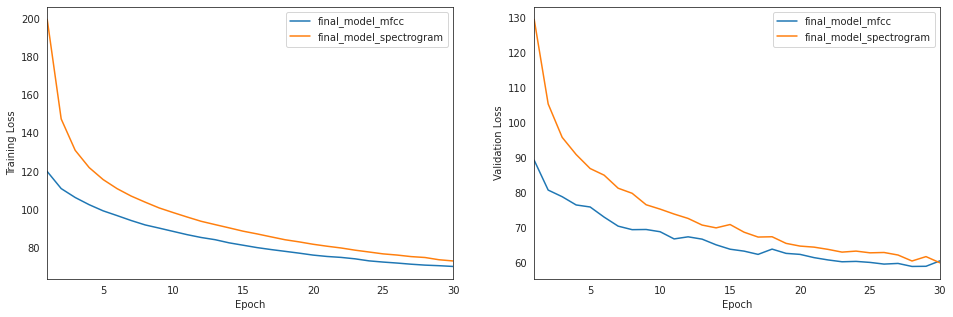

In [23]:
from model_viz import vizualise_model
%matplotlib inline
vizualise_model("final")

In [6]:
import numpy as np
from data_gen import AudioGenerator
from tensorflow.keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path,spectrogram=False):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=spectrogram)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

In [11]:
from model_use import ModelPredictor
predictor = ModelPredictor(input_to_softmax=final_model_mfcc,model_path='results/final_model_mfcc.h5')
from IPython.display import Audio

# display the true and predicted transcriptions and show the audio file
predictor.get_predictions_index(index=0, 
                partition='validation',                
                spectrogram = False)
print('-'*80)
Audio(predictor.audio_path)

array([[-1.81606604, -0.20503427,  0.50498271, ...,  1.42856888,
         0.209453  , -0.27933767],
       [-1.89711796, -0.0752861 ,  0.65560961, ...,  1.9734266 ,
         0.79333691,  0.16580954],
       [-1.90601512,  0.09433165,  0.60626843, ...,  1.96820663,
         0.61155644,  0.27747866],
       ...,
       [-1.80348609, -0.06118067,  0.68977924, ...,  1.57928274,
         0.54419806,  0.06768755],
       [-1.79271469,  0.01256302,  0.70303644, ...,  1.2385827 ,
         0.59616983, -0.19278313],
       [-1.77557729, -0.05790901,  0.61261673, ...,  1.16137102,
         0.60857253, -0.3367604 ]])
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
True transcription:

miss lake declined the carriage to night
--------------------------------------------------------------------------------
Predicted transcription:

miss rake to cind te carage to miht
--------------------------------------------------------------------------------
--

In [118]:
from model_use import ModelPredictor
from IPython.display import Audio
from voice_rec import voice_record

predictor = ModelPredictor(input_to_softmax=final_model_spectrogram,model_path='results/final_model_spectrogram.h5')
#voice_record()
# display the true and predicted transcriptions and show the audio file
predictor.get_predictions_recorded(spectrogram = True,recordingpath='recordings/demo2.wav')
print('-'*80)
Audio(predictor.audio_path)

array([[-3.32357366, -4.19901617, -3.9881478 , ..., -1.79770269,
        -1.81051032, -1.4816511 ],
       [-3.32357366, -4.19901617, -3.9881478 , ..., -1.79770269,
        -1.81051032, -1.4816511 ],
       [-3.32357366, -4.19901617, -3.9881478 , ..., -1.79770269,
        -1.81051032, -1.4816511 ],
       ...,
       [-3.32357366, -4.19901617, -3.9881478 , ..., -1.79770269,
        -1.81051032, -1.4816511 ],
       [-3.32357366, -4.19901617, -3.9881478 , ..., -1.79770269,
        -1.81051032, -1.4816511 ],
       [-3.32357366, -4.19901617, -3.9881478 , ..., -1.79770269,
        -1.81051032, -1.4816511 ]])
--------------------------------------------------------------------------------
Predicted transcription:

thes goo
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [119]:
from model_use import ModelPredictor
from IPython.display import Audio
from voice_rec import voice_record

predictor = ModelPredictor(input_to_softmax=final_model_mfcc,model_path='results/final_model_mfcc.h5')
#voice_record()
# display the true and predicted transcriptions and show the audio file
predictor.get_predictions_recorded(spectrogram = False,recordingpath='recordings/demo2.wav')
print('-'*80)
Audio(predictor.audio_path)

array([[-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       ...,
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869],
       [-12.38327635,   0.22523064,   0.39663492, ...,   0.28623942,
          0.26414991,   0.37054869]])
--------------------------------------------------------------------------------
Predicted transcription:

leks go
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [ ]:
get_predictions(index=3, 
                partition='validation',
                input_to_softmax=final_model_spectrogram, 
                model_path='results/final_model_spectrogram.h5',
                spectrogram = True)